# Reparam v2 Pipeline

Non-centered parameterization with improved optimization:
- **Cosine annealing** LR (0.1 → 0.001 over 500 epochs)
- **Gradient clipping** (max_norm=5.0)
- **Early stopping** (patience=75, best-state restore)

### Why v2?
v1 reparam used vanilla Adam for 200 epochs — loss was still declining at epoch 200.
v2 runs 500 epochs with smooth LR decay, reaching loss 44.4 vs v1's 49.5 (10% improvement).
Higher kappa (5.27 vs 4.52) and larger gamma (0.135 vs 0.081).

### Pipeline
1. **Training** — 40 batches × 10k patients (overnight, ~10 hrs)
2. **Pool + diagnose** — average params, check stability
3. **LOO predictions** — 5 batches × 10k, leave-one-out pooling
4. **AUC evaluation** — static 10yr, dynamic 10yr, dynamic 1yr

In [ ]:
import sys, os, glob, time, warnings
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from pathlib import Path

warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Paths
V2_TRAIN_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/censor_e_batchrun_vectorized_REPARAM_v2'
V2_LOO_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox/enrollment_predictions_fixedphi_fixedgk_reparam_v2_loo/'
DATA_DIR = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/'
COV_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/baselinagefamh_withpcs.csv'
PCE_PATH = '/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/pce_prevent_full.csv'

BATCH_SIZE = 10000
N_TRAIN_BATCHES = 40
N_PRED_BATCHES = 5
N_EVAL = N_PRED_BATCHES * BATCH_SIZE  # 50k

---
## Step 1: Training (already done)

Ran overnight via:
```bash
source ~/.bash_profile && conda activate new_env_pyro2
nohup env PYTHONUNBUFFERED=1 python claudefile/run_all_batches_v2.py > claudefile/logs/run_all_v2.log 2>&1 &
```

Each batch: `train_reparam_v2.py` with `fit_v2()` — cosine annealing, grad clipping, 500 epochs.

Check how many batches completed:

In [ ]:
pattern = str(Path(V2_TRAIN_DIR) / 'enrollment_model_REPARAM_W0.0001_batch_*_*.pt')
files = sorted(glob.glob(pattern))
print(f'Completed: {len(files)}/{N_TRAIN_BATCHES} batches')
for f in files[:3]:
    print(f'  {Path(f).name}')
if len(files) > 3:
    print(f'  ...')
    print(f'  {Path(files[-1]).name}')

Completed: 40/40 batches
  enrollment_model_REPARAM_W0.0001_batch_0_10000.pt
  enrollment_model_REPARAM_W0.0001_batch_100000_110000.pt
  enrollment_model_REPARAM_W0.0001_batch_10000_20000.pt
  ...
  enrollment_model_REPARAM_W0.0001_batch_90000_100000.pt


---
## Step 2: Pool parameters + diagnostics

Average phi, psi, gamma, kappa across all training batches.
Check stability: are kappa/gamma consistent across batches?

In [ ]:
def _extract(ckpt, name):
    if 'model_state_dict' in ckpt and name in ckpt['model_state_dict']:
        return ckpt['model_state_dict'][name]
    return ckpt.get(name)

all_phi, all_psi, all_kappa, all_gamma, all_losses = [], [], [], [], []
batch_labels = []

for fp in files:
    ckpt = torch.load(fp, weights_only=False)
    phi = _extract(ckpt, 'phi')
    gamma = _extract(ckpt, 'gamma')
    if phi is None or gamma is None:
        continue
    phi = phi.detach().cpu().numpy() if torch.is_tensor(phi) else np.array(phi)
    gamma = gamma.detach().cpu().numpy() if torch.is_tensor(gamma) else np.array(gamma)
    psi = _extract(ckpt, 'psi')
    if psi is not None:
        psi = psi.detach().cpu().numpy() if torch.is_tensor(psi) else np.array(psi)
    kappa = _extract(ckpt, 'kappa')
    k = kappa.item() if torch.is_tensor(kappa) else float(kappa) if kappa is not None else 1.0
    losses = ckpt.get('losses', [])
    
    all_phi.append(phi)
    all_psi.append(psi)
    all_kappa.append(k)
    all_gamma.append(gamma)
    all_losses.append(losses)
    batch_labels.append(Path(fp).stem.replace('enrollment_model_REPARAM_W0.0001_', ''))

n = len(all_phi)
print(f'Loaded {n} batches')

Loaded 40 batches


In [ ]:
# Pool
phi_pooled = np.mean(np.stack(all_phi), axis=0)
kappa_pooled = float(np.mean(all_kappa))
gamma_pooled = np.mean(np.stack(all_gamma), axis=0)
psi_valid = [p for p in all_psi if p is not None]
psi_pooled = np.mean(np.stack(psi_valid), axis=0) if psi_valid else None

print(f'Pooled params ({n} batches):')
print(f'  phi:   {phi_pooled.shape}')
print(f'  kappa: {kappa_pooled:.4f}')
print(f'  gamma: {gamma_pooled.shape}, mean|gamma| = {np.abs(gamma_pooled).mean():.4f}')
if psi_pooled is not None:
    print(f'  psi:   {psi_pooled.shape}')

Pooled params (40 batches):
  phi:   (21, 348, 52)
  kappa: 5.5382
  gamma: (47, 21), mean|gamma| = 0.0768
  psi:   (21, 348)


In [ ]:
# Stability diagnostics
kappas = np.array(all_kappa)
gamma_mags = np.array([np.abs(g).mean() for g in all_gamma])
final_losses = np.array([L[-1] for L in all_losses if len(L) > 0])

print('Stability across batches:')
print(f'  kappa:      mean={kappas.mean():.4f}, std={kappas.std():.4f}, range=[{kappas.min():.4f}, {kappas.max():.4f}]')
print(f'  |gamma|:    mean={gamma_mags.mean():.4f}, std={gamma_mags.std():.4f}, range=[{gamma_mags.min():.4f}, {gamma_mags.max():.4f}]')
if len(final_losses) > 0:
    print(f'  final loss: mean={final_losses.mean():.2f}, std={final_losses.std():.2f}, range=[{final_losses.min():.2f}, {final_losses.max():.2f}]')

Stability across batches:
  kappa:      mean=5.5382, std=0.1460, range=[5.2702, 5.7934]
  |gamma|:    mean=0.1276, std=0.0107, range=[0.1054, 0.1459]
  final loss: mean=44.69, std=0.40, range=[43.63, 45.49]


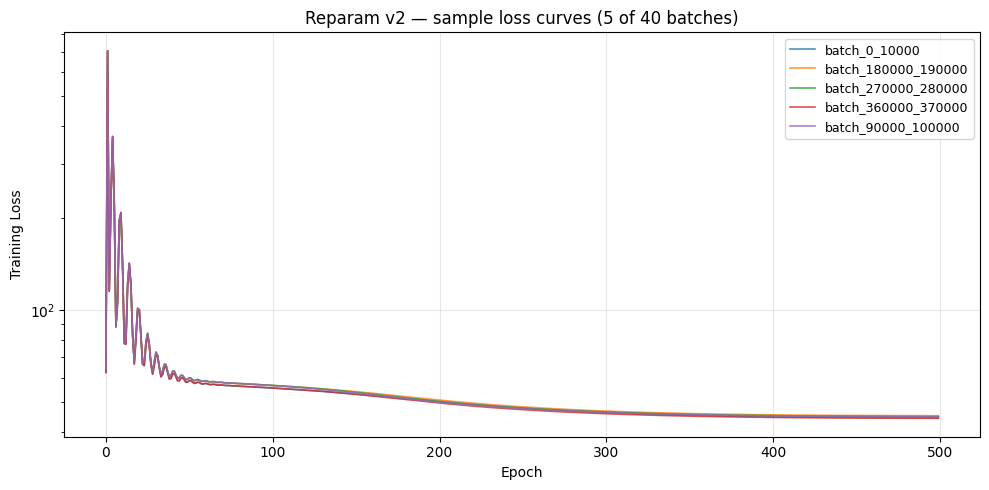

In [ ]:
# Plot sample loss curves
sample_idx = [0, n//4, n//2, 3*n//4, n-1] if n >= 5 else list(range(n))
sample_idx = sorted(set(sample_idx))

fig, ax = plt.subplots(figsize=(10, 5))
for i in sample_idx:
    if len(all_losses[i]) > 0:
        ax.plot(all_losses[i], linewidth=1.2, alpha=0.8, label=batch_labels[i])
ax.set_xlabel('Epoch')
ax.set_ylabel('Training Loss')
ax.set_title(f'Reparam v2 — sample loss curves ({len(sample_idx)} of {n} batches)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

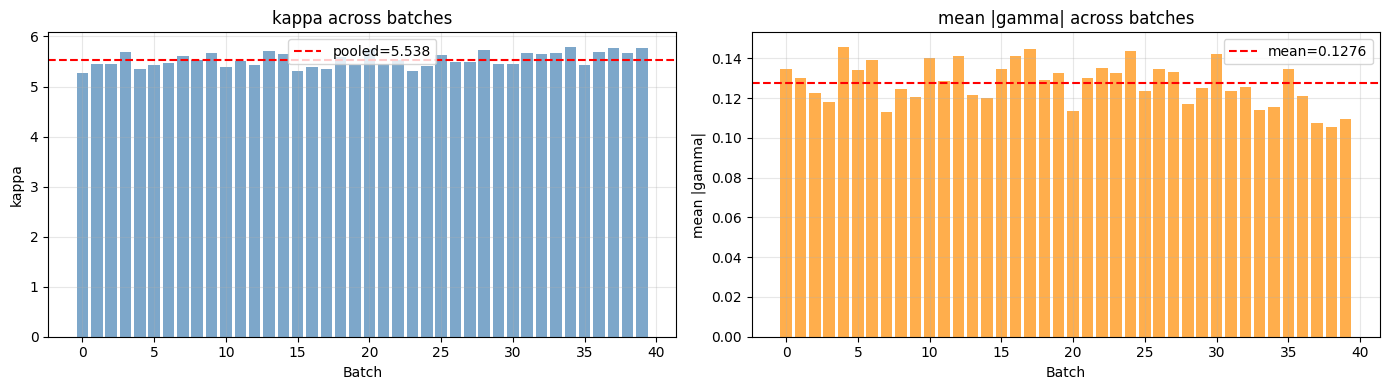

In [ ]:
# Kappa and |gamma| across batches
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.bar(range(n), kappas, color='steelblue', alpha=0.7)
ax1.axhline(kappa_pooled, color='red', ls='--', label=f'pooled={kappa_pooled:.3f}')
ax1.set_xlabel('Batch')
ax1.set_ylabel('kappa')
ax1.set_title('kappa across batches')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.bar(range(n), gamma_mags, color='darkorange', alpha=0.7)
ax2.axhline(gamma_mags.mean(), color='red', ls='--', label=f'mean={gamma_mags.mean():.4f}')
ax2.set_xlabel('Batch')
ax2.set_ylabel('mean |gamma|')
ax2.set_title('mean |gamma| across batches')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Save pooled params
out_path = Path(DATA_DIR) / 'pooled_phi_kappa_gamma_reparam_v2.pt'
save_dict = {
    'phi': phi_pooled, 'kappa': kappa_pooled, 'gamma': gamma_pooled,
    'n_batches': n, 'model_type': 'reparam_v2',
}
if psi_pooled is not None:
    save_dict['psi'] = psi_pooled
torch.save(save_dict, out_path)
print(f'Saved: {out_path}')

Saved: /Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/pooled_phi_kappa_gamma_reparam_v2.pt


In [ ]:
%run /Users/sarahurbut/aladynoulli2/claudefile/plot_lambda_curves_nolr_vs_reparam.py --batch 0 --n_patients 4 --n_epochs 100

SyntaxError: EOL while scanning string literal (plot_lambda_curves_nolr_vs_reparam.py, line 137)

---
## Step 3: LOO Predictions

For each of 5 prediction batches (50k patients):
- Pool phi/psi/gamma/kappa from 39 training batches (exclude self)
- Fit delta for each individual (lambda = G*gamma + delta)
- Save pi tensor

This takes ~1.5 hrs. Run in terminal:
```bash
nohup env PYTHONUNBUFFERED=1 python claudefile/run_loo_predict_v2.py > claudefile/logs/loo_predict_v2.log 2>&1 &
```

Or run inline (will block the notebook):

In [ ]:
import gc

sys.path.insert(0, str(Path('claudefile/aws_offsetmaster').resolve()))
from clust_huge_amp_fixedPhi_vectorized_fixed_gamma_fixed_kappa_REPARAM import (
    AladynSurvivalFixedPhiFixedGammaFixedKappaReparam,
)

# Load data
print('Loading data...')
Y = torch.load(DATA_DIR + 'Y_tensor.pt', weights_only=False)
E = torch.load(DATA_DIR + 'E_enrollment_full.pt', weights_only=False)
G = torch.load(DATA_DIR + 'G_matrix.pt', weights_only=False)
essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']
refs = torch.load(DATA_DIR + 'reference_trajectories.pt', weights_only=False)
signature_refs = refs['signature_refs']; del refs
prevalence_t = torch.load(DATA_DIR + 'prevalence_t_corrected.pt', weights_only=False)
fh = pd.read_csv(COV_PATH)
print(f'Y: {Y.shape}, E: {E.shape}, G: {G.shape}')

In [ ]:
def loo_pool(all_phi, all_psi, all_kappa, all_gamma, exclude_idx):
    idx = [j for j in range(len(all_phi)) if j != exclude_idx]
    phi = np.mean(np.stack([all_phi[j] for j in idx]), axis=0)
    kappa = float(np.mean([all_kappa[j] for j in idx]))
    gamma = np.mean(np.stack([all_gamma[j] for j in idx]), axis=0)
    psi_v = [all_psi[j] for j in idx if all_psi[j] is not None]
    psi = np.mean(np.stack(psi_v), axis=0) if psi_v else None
    return phi, psi, kappa, gamma

os.makedirs(V2_LOO_DIR, exist_ok=True)
NUM_EPOCHS = 200
LR = 1e-1

for batch_idx in range(N_PRED_BATCHES):
    start = batch_idx * BATCH_SIZE
    stop = (batch_idx + 1) * BATCH_SIZE
    pi_path = os.path.join(V2_LOO_DIR, f'pi_enroll_fixedphi_sex_{start}_{stop}.pt')

    print(f'\n{"="*70}')
    print(f'BATCH {batch_idx+1}/{N_PRED_BATCHES}: samples {start}-{stop} (LOO: exclude batch {batch_idx})')
    print(f'{"="*70}')

    if os.path.exists(pi_path):
        print('  Already exists, skipping')
        continue

    # Subset
    Y_b, E_b, G_b = Y[start:stop], E[start:stop], G[start:stop]
    sub = fh.iloc[start:stop].reset_index(drop=True)
    sex = sub['sex'].values if 'sex' in sub.columns else sub['Sex'].map({'Female':0,'Male':1}).values
    pcs = sub[[f'f.22009.0.{i}' for i in range(1,11)]].values
    G_ws = np.column_stack([G_b, sex, pcs])

    # LOO pool
    phi, psi, kappa, gamma = loo_pool(all_phi, all_psi, all_kappa, all_gamma, batch_idx)
    print(f'  LOO kappa={kappa:.4f}, mean|gamma|={np.abs(gamma).mean():.4f}')

    # Fit
    torch.manual_seed(42); np.random.seed(42)
    N_b, D, T = Y_b.shape
    K = phi.shape[0] - 1 if phi.shape[0] == 21 else phi.shape[0]

    model = AladynSurvivalFixedPhiFixedGammaFixedKappaReparam(
        N=N_b, D=D, T=T, K=K, P=G_ws.shape[1],
        G=G_ws, Y=Y_b, R=0, W=0.0001, prevalence_t=prevalence_t,
        init_sd_scaler=1e-1, genetic_scale=1,
        pretrained_phi=phi, pretrained_psi=psi,
        pretrained_gamma=gamma, pretrained_kappa=kappa,
        signature_references=signature_refs, healthy_reference=True,
        disease_names=disease_names,
    )

    t0 = time.time()
    result = model.fit(E_b, num_epochs=NUM_EPOCHS, learning_rate=LR)
    losses = result[0] if isinstance(result, tuple) else result
    elapsed = (time.time() - t0) / 60
    print(f'  Loss: {losses[-1]:.4f}, Time: {elapsed:.1f} min')

    with torch.no_grad():
        pi, _, _ = model.forward()
    if torch.isnan(pi).any():
        print(f'  WARNING: NaN in pi, clamping')
        pi = torch.nan_to_num(pi, nan=0.0).clamp(1e-8, 1-1e-8)

    torch.save(pi, pi_path)
    print(f'  Saved: {pi_path}')
    del model, pi; gc.collect()

---
## Step 4: AUC Evaluation

Load the 5 LOO pi tensors, evaluate 3 AUC metrics:
- Static 10-year
- Dynamic 10-year  
- Dynamic 1-year

In [ ]:
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts/')
from fig5utils import (
    evaluate_major_diseases_wsex_with_bootstrap_from_pi,
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi,
)
from evaluatetdccode import (
    evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex
)

# Load pi
print('Loading v2 LOO predictions...')
pi_batches = []
for i in range(N_PRED_BATCHES):
    s, e = i * BATCH_SIZE, (i+1) * BATCH_SIZE
    f = Path(V2_LOO_DIR) / f'pi_enroll_fixedphi_sex_{s}_{e}.pt'
    pi = torch.load(f, map_location='cpu', weights_only=False)
    pi_batches.append(pi)
    print(f'  {f.name}: {pi.shape}')
pi_v2 = torch.cat(pi_batches, dim=0)
print(f'Combined: {pi_v2.shape}')

# Load evaluation data
Y_eval = torch.load(DATA_DIR + 'Y_tensor.pt', weights_only=False)[:N_EVAL]
E_eval = torch.load(DATA_DIR + 'E_enrollment_full.pt', weights_only=False)[:N_EVAL]
essentials = torch.load(DATA_DIR + 'model_essentials.pt', weights_only=False)
disease_names = essentials['disease_names']

pce_df = pd.read_csv(PCE_PATH).iloc[:N_EVAL].reset_index(drop=True)
if 'Sex' not in pce_df.columns and 'sex' in pce_df.columns:
    pce_df['Sex'] = pce_df['sex'].map({0: 'Female', 1: 'Male'}).fillna('Unknown')
if 'sex' not in pce_df.columns and 'Sex' in pce_df.columns:
    pce_df['sex'] = pce_df['Sex'].map({'Female': 0, 'Male': 1}).fillna(-1)
if 'age' not in pce_df.columns and 'Age' in pce_df.columns:
    pce_df['age'] = pce_df['Age']

print(f'Y: {Y_eval.shape}, E: {E_eval.shape}, pce_df: {len(pce_df)}')

Loading v2 LOO predictions...
  pi_enroll_fixedphi_sex_0_10000.pt: torch.Size([10000, 348, 52])
  pi_enroll_fixedphi_sex_10000_20000.pt: torch.Size([10000, 348, 52])
  pi_enroll_fixedphi_sex_20000_30000.pt: torch.Size([10000, 348, 52])
  pi_enroll_fixedphi_sex_30000_40000.pt: torch.Size([10000, 348, 52])
  pi_enroll_fixedphi_sex_40000_50000.pt: torch.Size([10000, 348, 52])
Combined: torch.Size([50000, 348, 52])
Y: torch.Size([50000, 348, 52]), E: torch.Size([50000, 348]), pce_df: 50000


In [ ]:
N_BOOTSTRAPS = 100

def evaluate_horizon(pi, Y, E, disease_names, pce_df, n_bootstraps, horizon):
    if horizon == 'static_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_10yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_from_pi(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps, follow_up_duration_years=10)
    elif horizon == 'dynamic_1yr':
        results = evaluate_major_diseases_wsex_with_bootstrap_dynamic_1year_different_start_end_numeric_sex(
            pi=pi, Y_100k=Y, E_100k=E, disease_names=disease_names,
            pce_df=pce_df, n_bootstraps=n_bootstraps)
    rows = []
    for disease, m in results.items():
        rows.append({'disease': disease, 'auc': m.get('auc', np.nan),
                     'ci_lower': m.get('ci_lower', np.nan),
                     'ci_upper': m.get('ci_upper', np.nan),
                     'n_events': m.get('n_events', 0)})
    return pd.DataFrame(rows)

In [ ]:
all_results = []

for horizon in ['static_10yr', 'dynamic_10yr', 'dynamic_1yr']:
    print(f'\n{"="*70}')
    print(f'  {horizon.upper()}')
    print(f'{"="*70}')
    df = evaluate_horizon(pi_v2, Y_eval, E_eval, disease_names, pce_df, N_BOOTSTRAPS, horizon)
    df['horizon'] = horizon
    
    # Print
    print(f'{"DISEASE":<25} {"AUC (95% CI)":<30} {"N_EVENTS":>10}')
    print('-' * 70)
    for _, r in df.iterrows():
        ci = f"{r['auc']:.3f} ({r['ci_lower']:.3f}-{r['ci_upper']:.3f})"
        print(f"{r['disease']:<25} {ci:<30} {int(r['n_events']):>10}")
    print(f"\nMean AUC: {df['auc'].mean():.4f}")
    all_results.append(df)

combined = pd.concat(all_results, ignore_index=True)


  STATIC_10YR

Evaluating ASCVD (10-Year Outcome, 1-Year Score)...
AUC: 0.754 (0.746-0.760) (calculated on 50000 individuals)
Events (10-Year in Eval Cohort): 4333 (8.7%) (from 50000 individuals)
Excluded 0 prevalent cases for ASCVD.

   Sex-stratified analysis:
   Female: AUC = 0.739, Events = 1446/27107
   Male: AUC = 0.736, Events = 2887/22893

   ASCVD risk in patients with pre-existing conditions:
   RA: AUC = 0.767, Events = 36/248
   Breast_Cancer: AUC = 0.728, Events = 48/840

Evaluating Diabetes (10-Year Outcome, 1-Year Score)...
AUC: 0.713 (0.704-0.720) (calculated on 50000 individuals)
Events (10-Year in Eval Cohort): 2921 (5.8%) (from 50000 individuals)
Excluded 0 prevalent cases for Diabetes.

   Sex-stratified analysis:
   Female: AUC = 0.719, Events = 1193/27107
   Male: AUC = 0.713, Events = 1728/22893

Evaluating Atrial_Fib (10-Year Outcome, 1-Year Score)...
AUC: 0.750 (0.741-0.762) (calculated on 49353 individuals)
Events (10-Year in Eval Cohort): 1919 (3.8%) (from 5

In [ ]:
# Summary
print('\nSUMMARY — Reparam v2 LOO AUC')
print('=' * 50)
for horizon in ['static_10yr', 'dynamic_10yr', 'dynamic_1yr']:
    h = combined[combined['horizon'] == horizon]
    print(f'  {horizon:<15}: mean AUC = {h["auc"].mean():.4f}')


SUMMARY — Reparam v2 LOO AUC
  static_10yr    : mean AUC = 0.6324
  dynamic_10yr   : mean AUC = 0.6050
  dynamic_1yr    : mean AUC = 0.8215


In [ ]:
# Save
out_csv = '/Users/sarahurbut/aladynoulli2/claudefile/reparam_v2_auc_LOO.csv'
combined.to_csv(out_csv, index=False)
print(f'Saved: {out_csv}')

Saved: /Users/sarahurbut/aladynoulli2/claudefile/reparam_v2_auc_LOO.csv
